# [Optional] Process docs into database

You can directly use `data/shadcn.csv`. If you want to know how I preprocess the data, you can take a look at this notebook.

I use shadcn library as components, downloaded two directories as the data source.

`source code for components`: [GitHub](https://github.com/shadcn-ui/ui/tree/main/apps/www/components)

I used this for extracting metadata, including description and usage_example. (later i found resource below lol) But still useful for using LLM to extract metadata.

`description for components`: [GitHub](https://github.com/shadcn-ui/ui/tree/main/apps/www/content/docs/components)

I used this as prompt.

## 1. Imports

In [6]:
import os
from dotenv import load_dotenv
import tiktoken

load_dotenv()

def num_tokens_from_string(string: str, model="gpt-3.5-turbo-0613") -> int:
    """Returns the number of tokens in a text string based on the specified model's encoding."""
    try:
        encoding = tiktoken.encoding_for_model(model)  # Attempt to get encoding for the specified model
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")  # Fallback encoding if model's encoding not found

    num_tokens = len(encoding.encode(string))  # Calculate number of tokens based on encoding
    return num_tokens

# function: read a file and return {"file_name": "xxx", "file_content": "xxx", "file_path": "xxx", "token": "xxx"}
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        file_content = f.read()
        return {"file_name": os.path.basename(file_path), "file_content": file_content, "file_path": file_path, "token": num_tokens_from_string(file_content)}

In [8]:
# You can change the path to see if it works
# test_path = "www\\components\\analytics.tsx"
# print(read_file(test_path))

{'file_name': 'analytics.tsx', 'file_content': '"use client"\n\nimport { Analytics as VercelAnalytics } from "@vercel/analytics/react"\n\nexport function Analytics() {\n  return <VercelAnalytics />\n}\n', 'file_path': 'www\\components\\analytics.tsx', 'token': 34}


In [113]:
data_path = "www\\registry\\default\\ui"

# walk through the directory and read all the files into pandas dataframe
import pandas as pd
data = []
for root, dirs, files in os.walk(data_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith(('.tsx')):
            data.append(read_file(file_path))

df = pd.DataFrame(data)
print(df.head())
print(df.info())


          file_name                                       file_content  \
0     accordion.tsx  "use client"\n\nimport * as React from "react"...   
1  alert-dialog.tsx  "use client"\n\nimport * as React from "react"...   
2         alert.tsx  import * as React from "react"\nimport { cva, ...   
3  aspect-ratio.tsx  "use client"\n\nimport * as AspectRatioPrimiti...   
4        avatar.tsx  "use client"\n\nimport * as React from "react"...   

                                  file_path  token  
0     www\registry\default\ui\accordion.tsx    446  
1  www\registry\default\ui\alert-dialog.tsx    969  
2         www\registry\default\ui\alert.tsx    404  
3  www\registry\default\ui\aspect-ratio.tsx     34  
4        www\registry\default\ui\avatar.tsx    311  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file_name     44 non-null     object
 1   file

## 2. Metadata Extraction

In [26]:
example_data = data[0]


Summarzie the following component "{name}" into json with attributes of description and usage example 

===
{content}


In [38]:
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers.json import SimpleJsonOutputParser

I used langchain and jsonparser to extract metadata.

In [93]:
template = """\
Summarzie the following component "{file_name}" into json with attributes of description and usage_example

description: describe the function and feature
usage_example: call the component with some example code in tsx, include possible props; only output example code in tsx
props: list all the props and their types, separated by comma;

only output json

Output Format:
{{
    "description": insert_description_here,
    "usage_example": insert_usage_example_here(use ' instead of "),
    "props": insert_props_here
}}
===
{file_content}"""
prompt = ChatPromptTemplate.from_template(template)
print(prompt)

json_parser = SimpleJsonOutputParser()

input_variables=['file_content', 'file_name'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['file_content', 'file_name'], template='Summarzie the following component "{file_name}" into json with attributes of description and usage_example\n\ndescription: describe the function and feature\nusage_example: call the component with some example code in tsx, include possible props; only output example code in tsx\nprops: list all the props and their types, separated by comma;\n\nonly output json\n\nOutput Format:\n{{\n    "description": insert_description_here,\n    "usage_example": insert_usage_example_here(use \' instead of "),\n    "props": insert_props_here\n}}\n===\n{file_content}'))]


In [103]:
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0.6, max_tokens=1024, model="gpt-4-turbo-preview")
parser = JsonOutputParser()
llm_chain = (
    prompt 
    | llm 
    | parser
    )

In [104]:
%%time
# dataframe to list
data_list = df.to_dict(orient='records')
# batch run the langchain
results = llm_chain.batch(data_list)

CPU times: total: 1.81 s
Wall time: 23.2 s


In [114]:
# output to dataframe
output_df = pd.DataFrame(results)
# add to original dataframe
df_meta = pd.concat([df, output_df], axis=1)
# output to csv
df_meta.to_csv("output.csv", index=False)

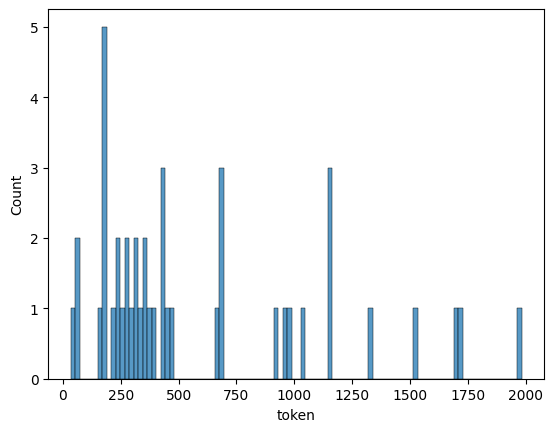

In [106]:
# plot token distribution in plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df.token, bins=100)
plt.show()

## 3. Database based on metadata

In [40]:
def get_combined_meta_string(data_entry):
    return f"----- START OF {data_entry['file_name']} -----\ndescription:\n{data_entry['description']}\n----- END OF {data_entry['file_name']} -----\n\n"

def read_combined_file(data_path):
    # data_path is the csv file path of df_meta
    df_meta = pd.read_csv(data_path)
    combined_list = [get_combined_meta_string(data_entry) for data_entry in df_meta.to_dict(orient='records')]
    # get combined string
    combined_string = "".join(combined_list)
    return combined_string

In [41]:
combined_string = read_combined_file("output.csv")
print(num_tokens_from_string(combined_string))

4020


In [122]:
df_meta.head()

,file_content,file_path,token,description,usage_example,props
file_name,,,,,,
accordion.tsx,"""use client""\n\nimport * as React from ""react""...",www\registry\default\ui\accordion.tsx,446,This component is a customizable accordion fea...,<Accordion defaultValue='item1' type='single' ...,"Accordion: defaultValue: string, type: 'single..."
alert-dialog.tsx,"""use client""\n\nimport * as React from ""react""...",www\registry\default\ui\alert-dialog.tsx,969,This component is a comprehensive implementati...,<AlertDialog>\n <AlertDialogTrigger asChild>\...,"AlertDialog: None, AlertDialogPortal: None, Al..."
alert.tsx,"import * as React from ""react""\nimport { cva, ...",www\registry\default\ui\alert.tsx,404,The `Alert` component is designed to display a...,<Alert variant='destructive'><svg>...</svg><di...,"className: string, variant: 'default' | 'destr..."
aspect-ratio.tsx,"""use client""\n\nimport * as AspectRatioPrimiti...",www\registry\default\ui\aspect-ratio.tsx,34,The AspectRatio component is used to create a ...,<AspectRatio ratio={16 / 9} style={{ width: '1...,"ratio: number, style: CSSProperties, children:..."
avatar.tsx,"""use client""\n\nimport * as React from ""react""...",www\registry\default\ui\avatar.tsx,311,This component utilizes the Radix UI Avatar pa...,<Avatar className='custom-avatar-class'>\n <A...,"Avatar: className: string, AvatarImage: classN..."


## 4. Add mdx description

i found mdx files after i extracted metadata, so i stick to official description afterwards.

In [102]:
import os


# read from path and add to dataframe, for file_name "card.tsx", dir has another file called "card.mdx", read it and load to dataframe
def get_mdx_to_df(mdx_path, df):
    # walk through the directory and read all the files into pandas dataframe
    data = []
    for root, dirs, files in os.walk(mdx_path):
        for file in files:
            file_path = os.path.join(root, file)
            file_name = os.path.basename(file_path)\
            # change file_name to the corresponding tsx file
            file_name = file_name.replace(".mdx", ".tsx")
            print(file_name, file_path)
            # 检查是否是代码文件，此处可以根据需要调整条件
            if file_path.endswith(('.mdx')):
                with open(file_path, 'r', encoding='utf-8') as f:
                    file_content = f.read()
                    data.append({"file_name": file_name,"mdx_description": file_content, "mdx_token": num_tokens_from_string(file_content)})
    df_mdx = pd.DataFrame(data)
    print(df_mdx.head())
    # concat with index = file_name
    df = df.set_index('file_name').join(df_mdx.set_index('file_name')).reset_index()
    return df

# download https://github.com/shadcn-ui/ui/tree/main/apps/www/content/docs/components and change the path below
mdx_path = "components"
df_meta_2 = get_mdx_to_df(mdx_path, df_meta)

accordion.tsx components\accordion.mdx
alert-dialog.tsx components\alert-dialog.mdx
alert.tsx components\alert.mdx
aspect-ratio.tsx components\aspect-ratio.mdx
avatar.tsx components\avatar.mdx
badge.tsx components\badge.mdx
button.tsx components\button.mdx
calendar.tsx components\calendar.mdx
card.tsx components\card.mdx
carousel.tsx components\carousel.mdx
checkbox.tsx components\checkbox.mdx
collapsible.tsx components\collapsible.mdx
combobox.tsx components\combobox.mdx
command.tsx components\command.mdx
context-menu.tsx components\context-menu.mdx
data-table.tsx components\data-table.mdx
date-picker.tsx components\date-picker.mdx
dialog.tsx components\dialog.mdx
drawer.tsx components\drawer.mdx
dropdown-menu.tsx components\dropdown-menu.mdx
form.tsx components\form.mdx
hover-card.tsx components\hover-card.mdx
input.tsx components\input.mdx
label.tsx components\label.mdx
menubar.tsx components\menubar.mdx
navigation-menu.tsx components\navigation-menu.mdx
pagination.tsx components\pa

In [103]:
df_meta_2.head()

,file_name,file_content,file_path,token,description,usage_example,props,mdx_description,mdx_token
0,accordion.tsx,"""use client""\n\nimport * as React from ""react""...",www\registry\default\ui\accordion.tsx,446,This component is a customizable accordion fea...,<Accordion defaultValue='item1' type='single' ...,"Accordion: defaultValue: string, type: 'single...",---\ntitle: Accordion\ndescription: A vertical...,749.0
1,alert-dialog.tsx,"""use client""\n\nimport * as React from ""react""...",www\registry\default\ui\alert-dialog.tsx,969,This component is a comprehensive implementati...,<AlertDialog>\n <AlertDialogTrigger asChild>\...,"AlertDialog: None, AlertDialogPortal: None, Al...",---\ntitle: Alert Dialog\ndescription: A modal...,404.0
2,alert.tsx,"import * as React from ""react""\nimport { cva, ...",www\registry\default\ui\alert.tsx,404,The `Alert` component is designed to display a...,<Alert variant='destructive'><svg>...</svg><di...,"className: string, variant: 'default' | 'destr...",---\ntitle: Alert\ndescription: Displays a cal...,267.0
3,aspect-ratio.tsx,"""use client""\n\nimport * as AspectRatioPrimiti...",www\registry\default\ui\aspect-ratio.tsx,34,The AspectRatio component is used to create a ...,<AspectRatio ratio={16 / 9} style={{ width: '1...,"ratio: number, style: CSSProperties, children:...",---\ntitle: Aspect Ratio\ndescription: Display...,309.0
4,avatar.tsx,"""use client""\n\nimport * as React from ""react""...",www\registry\default\ui\avatar.tsx,311,This component utilizes the Radix UI Avatar pa...,<Avatar className='custom-avatar-class'>\n <A...,"Avatar: className: string, AvatarImage: classN...",---\ntitle: Avatar\ndescription: An image elem...,280.0


In [104]:
df_meta_2.to_csv("output_2.csv", index=True, index_label="file_name")

# Reload from dataset

In [1]:
import tiktoken

def num_tokens_from_string(string: str, model="gpt-3.5-turbo-0613") -> int:
    """Returns the number of tokens in a text string based on the specified model's encoding."""
    try:
        encoding = tiktoken.encoding_for_model(model)  # Attempt to get encoding for the specified model
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")  # Fallback encoding if model's encoding not found

    num_tokens = len(encoding.encode(string))  # Calculate number of tokens based on encoding
    return num_tokens


In [2]:
import pandas as pd

def retrieve_component_from_df(df_meta, file_name):
    # only return json object
    data_entry = df_meta[df_meta['file_name'] == file_name]
    # return the first one
    # if not exist, return empty json object
    if data_entry.empty:
        return {}
    return data_entry.to_dict(orient='records')[0]

def get_combined_context_string(data_entry):
    # include file_name, description, usage_example, file_content
    # use mdx description instead
    context = f"----- START OF {data_entry['file_name']} -----\
    description:\
    {data_entry['mdx_description']}\
    raw_code:\
    {data_entry['file_content']}\
    ----- END OF {data_entry['file_name']} -----\n\n"
    
    return {"context": context, "token": num_tokens_from_string(context)}

def get_combined_contexts(df_meta, file_names):
    # list of file_names -> list of combined context strings, also count token of each context
    combined_contexts = {}
    for file_name in file_names:
        data_entry = retrieve_component_from_df(df_meta, file_name)
        if data_entry:
            combined_contexts[file_name] = get_combined_context_string(data_entry)
    return combined_contexts

def contexts_to_string(combined_contexts):
    return "".join([combined_contexts[file_name]["context"] for file_name in combined_contexts])

def get_combined_meta_string(data_entry):
    return f"----- START OF {data_entry['file_name']} -----\ndescription:\n{data_entry['description']}\n----- END OF {data_entry['file_name']} -----\n\n"

def read_combined_file(data_path):
    # data_path is the csv file path of df_meta
    df_meta = pd.read_csv(data_path)
    combined_list = [get_combined_meta_string(data_entry) for data_entry in df_meta.to_dict(orient='records')]
    # get combined string
    combined_string = "".join(combined_list)
    return combined_string

In [3]:
import pandas as pd
data_path = "output.csv"
df = pd.read_csv(data_path, index_col=False)
combined_string = read_combined_file(data_path)

In [4]:
df.head()

,file_name,file_content,file_path,token,description,usage_example,props,mdx_description,mdx_token
0,accordion.tsx,"""use client""\n\nimport * as React from ""react""...",www\registry\default\ui\accordion.tsx,446,This component is a customizable accordion fea...,<Accordion defaultValue='item1' type='single' ...,"Accordion: defaultValue: string, type: 'single...",---\ntitle: Accordion\ndescription: A vertical...,749.0
1,alert-dialog.tsx,"""use client""\n\nimport * as React from ""react""...",www\registry\default\ui\alert-dialog.tsx,969,This component is a comprehensive implementati...,<AlertDialog>\n <AlertDialogTrigger asChild>\...,"AlertDialog: None, AlertDialogPortal: None, Al...",---\ntitle: Alert Dialog\ndescription: A modal...,404.0
2,alert.tsx,"import * as React from ""react""\nimport { cva, ...",www\registry\default\ui\alert.tsx,404,The `Alert` component is designed to display a...,<Alert variant='destructive'><svg>...</svg><di...,"className: string, variant: 'default' | 'destr...",---\ntitle: Alert\ndescription: Displays a cal...,267.0
3,aspect-ratio.tsx,"""use client""\n\nimport * as AspectRatioPrimiti...",www\registry\default\ui\aspect-ratio.tsx,34,The AspectRatio component is used to create a ...,<AspectRatio ratio={16 / 9} style={{ width: '1...,"ratio: number, style: CSSProperties, children:...",---\ntitle: Aspect Ratio\ndescription: Display...,309.0
4,avatar.tsx,"""use client""\n\nimport * as React from ""react""...",www\registry\default\ui\avatar.tsx,311,This component utilizes the Radix UI Avatar pa...,<Avatar className='custom-avatar-class'>\n <A...,"Avatar: className: string, AvatarImage: classN...",---\ntitle: Avatar\ndescription: An image elem...,280.0


In [5]:
combined_string

"----- START OF accordion.tsx -----\ndescription:\nThis component is a customizable accordion feature built with React and Radix UI. It consists of four main parts: Accordion (the container), AccordionItem (each item in the accordion), AccordionTrigger (the clickable part of each item to expand/collapse content), and AccordionContent (the content that is shown or hidden when the accordion item is triggered). The components are styled with utility classes and can be further customized via props.\n----- END OF accordion.tsx -----\n\n----- START OF alert-dialog.tsx -----\ndescription:\nThis component is a comprehensive implementation of an alert dialog using @radix-ui/react-alert-dialog primitives, providing a customizable and accessible dialog interface for alerting users. It encapsulates various parts of a dialog, such as the overlay, content, title, description, actions, and cancel button, each with customizable styling and functionality. The implementation ensures accessibility by usi

# Use Dspy to test it out

At first, i used Dspy to test the possibility of this chain, because i don't want to worry about prompting techniques.

However I discover it's really hard to customize when i want to do some magic on prompting.

I would say dspy is suitable for quickly constructing the agent / rag pipeline without considering much.

When you want to have more customization, using langgraph & langsmith is better choice for me.

P.S. it's hard to inspect what's happening inside dspy pipeline.

In [27]:
# model = 'gpt-3.5-turbo-0125'
model = "gpt-4-turbo-preview"

In [28]:
import dspy
turbo = dspy.OpenAI(model=model, temperature=0.6, max_tokens=4096)
dspy.settings.configure(lm=turbo)

In [41]:
# generate answer based on the combined string (as context) and query
class GenerateNeededComponents(dspy.Signature):
    """Generate a list of needed components based on the context and query. Choose from the components in shadcn library.\n\n"""

    question = dspy.InputField(desc="a query to build a frontend using components selected from shadcn library")
    components = dspy.InputField(desc="a list of components in shadcn library")
    needed_components = dspy.OutputField(desc="a full list of needed components name, rememeber to include .tsx, separated by comma")

# generate frontend outline based on the retrieved components and query
class GenerateOutline(dspy.Signature):
    """Generate a frontend outline based on the retrieved components and query. Choose from the components in shadcn library.\n\n"""

    question = dspy.InputField(desc="a query to build a frontend using components selected from shadcn library")
    components_selected = dspy.InputField(desc="a list of components that can need to be used in the frontend outline")
    components = dspy.InputField(desc="nessary components in shadcn library")
    frontend_outline = dspy.OutputField(desc="a frontend outline based on the retrieved components and query, use bullet points to describe the structure")

# generate final frontend code based on the retrieved components, query and frontend outline
class GenerateFrontendCode(dspy.Signature):
    """Generate a frontend code based on the shadcn components, query and frontend outline. Choose from the components in shadcn library. 
    Follow the frontend outline step by step.
    1. Use tailwind to make grid and layout.
    2. Use components to make the structure.
    3. Refer to the description to import the components.
    4. always generate whole page.tsx.
    5. dont use fake image.

    I will tip you 1000$ for complete the whole code without skipping any codes!!!!
    \n\n"""

    question = dspy.InputField(desc="a query to build a frontend using components selected from shadcn library")
    components_selected = dspy.InputField(desc="a list of components that can need to be used in the frontend outline")
    components = dspy.InputField(desc="nessary components in shadcn library")
    frontend_outline = dspy.InputField(desc="a frontend outline based on the retrieved components and query, use bullet points to describe the structure")
    frontend_code = dspy.OutputField(desc="a frontend code.")


In [42]:
class Chat2Frontend(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ChainOfThought(GenerateNeededComponents)
        self.generate_outline = dspy.ChainOfThought(GenerateOutline)
        self.generate_frontend_code = dspy.ChainOfThought(GenerateFrontendCode)
    
    def forward(self, question, df, combined_string):
        pred = self.generate_answer(question=question, components=combined_string)
        # print(pred.needed_components, "\n\n===\n\n")
        # logging.debug(pred.needed_components)

        file_names = [name.strip() for name in pred.needed_components.split(",") if name.strip()]
        combined_contexts = get_combined_contexts(df, file_names)
        components = contexts_to_string(combined_contexts)
        # print(components, "\n\n===\n\n")
        # logging.debug(components)


        result = self.generate_outline(question=question, components_selected=pred.needed_components, components=components)
        frontend_outline = result.frontend_outline
        # print(frontend_outline, "\n\n===\n\n")
        # logging.debug(frontend_outline)

        code = self.generate_frontend_code(question=question, components_selected=pred.needed_components, components=components, frontend_outline=frontend_outline)
        # print(code.frontend_code, "\n\n===\n\n")
        # logging.debug(code.frontend_code)
        return code.frontend_code

In [43]:
my_question = "generate a card for a dashboard page, you can select a topic"
chat2frontend = Chat2Frontend()
pred = chat2frontend(my_question, df, combined_string)

In [44]:
print(pred)

```tsx
import { Card, CardHeader, CardTitle, CardDescription, CardContent, CardFooter } from "@/components/ui/card";
import { Avatar } from "@/components/ui/avatar";
import { Badge } from "@/components/ui/badge";
import { Button } from "@/components/ui/button";

export default function WeatherDashboardCard() {
  return (
    <Card>
      <CardHeader>
        <CardTitle>Weather Dashboard</CardTitle>
        <CardDescription>Current Weather Status</CardDescription>
      </CardHeader>
      <CardContent>
        <div className="flex items-center space-x-4">
          <Avatar src="https://example.com/weather-icon.png"/>
          <div>
            <p>Temperature: <Badge variant="outline">24°C</Badge></p>
            <p>Humidity: <Badge variant="outline">60%</Badge></p>
            <p>Wind Speed: <Badge variant="outline">15 km/h</Badge></p>
          </div>
        </div>
      </CardContent>
      <CardFooter>
        <div className="flex space-x-2">
          <Button>Refresh</Button>
   

In [33]:
turbo.inspect_history(n=5)





Generate a list of needed components based on the context and query. Choose from the components in shadcn library.

---

Follow the following format.

Question: a query to build a frontend using components selected from shadcn library

Components: a list of components in shadcn library

Reasoning: Let's think step by step in order to ${produce the needed_components}. We ...

Needed Components: a full list of needed components name, rememeber to include .tsx, separated by comma

---

Question: a dashboard for stock price analysis

Components: ----- START OF accordion.tsx ----- description: This component is a customizable accordion feature built with React and Radix UI. It consists of four main parts: Accordion (the container), AccordionItem (each item in the accordion), AccordionTrigger (the clickable part of each item to expand/collapse content), and AccordionContent (the content that is shown or hidden when the accordion item is triggered). The components are styled with utility 

# Conclusion

After I pre-process the dataset, I immediately use Dspy to test it out. I found many interesting points:

- data pre-processing and metadata extraction are extremely important.

I found out sometimes the generated results will have wrong imports, it doesn't follow the instructions in the documents, so might need another metadata extracted from documents only for installation and imports of each components.

What i mean, is, identifying problems and go back to data preprocessing is a must.

- dspy is great for constructing prototype.

it's tricky to prompting in the first place. because sometimes we don't even know how the model will behave. but it's hard to stick to dspy, because i want to customize the prompt and model settings afterwards, so i switch to langgraph later.

components of dspy will have the same model, which is not suitable from cost perspective. i would like to use smaller model for lower cost in some easy tasks.